## mutation analysis

在关于覆盖率的章节中，我们展示了如何确定程序的哪些部分是由程序执行的，从而了解一组测试用例在覆盖程序结构方面的有效性。然而，仅仅是覆盖率可能不是衡量测试有效性的最好方法，因为人们可以有很好的覆盖率而不去检查结果的正确性。在本章中，我们将介绍另一种评估测试套件有效性的方法。在代码中注入突变--人工故障--之后，我们检查测试套件是否能够检测到这些人工故障。我们的想法是，如果它不能检测到这种突变，它也会错过真正的错误。

In [225]:
from fuzzingbook.MutationAnalysis import MuFunctionAnalyzer

#### why structure coverage is not enough
结构性覆盖措施的一个问题是，它没有检查测试套件生成的程序执行是否真的正确。也就是说，一个产生错误输出的执行没有被测试套件注意到，它和一个产生正确输出的执行的覆盖率计算是完全一样的。事实上，如果删除一个典型的测试案例中的断言，对于新的测试套件来说，覆盖率不会改变，但新的测试套件比原来的测试套件的作用要小得多。作为一个例子，考虑这个 "测试"。

然而，这些 "测试 "的问题是，execute_the_program_as_a_whole()可能达到100%的代码覆盖率（或任何其他结构覆盖率指标的100%）。然而，这个100%的数字并不反映测试发现错误的能力，实际上是0%。

这的确不是一个最佳状态。我们如何验证我们的测试是否真的有用呢？一种替代方法（在关于覆盖率的章节中暗示过）是在程序中注入bug，并评估测试套件在捕捉这些注入的bug方面的有效性。然而，这又引入了另一个问题。首先，我们如何产生这些bug？任何人工的努力都有可能被开发者的先入为主的观念所影响，即错误可能发生在哪里，以及会产生什么影响。此外，编写好的bug可能会花费大量的时间，而带来非常间接的好处。因此，这样的解决方案是不够的。

#### 用突变分析法产生人工故障

突变分析为评估测试套件的有效性提供了一个替代解决方案。突变分析的想法是在程序代码中加入人工故障，称为突变，并检查测试套件是否发现它们。例如，这样的突变可以在execute_the_program_as_a_whole()中的某个地方用一个-替换一个+。当然，上述无效的测试不会发现这一点，因为它们没有检查任何结果。然而，一个有效的测试会；假设一个测试在发现人为故障方面越有效，它在发现真实故障方面就越有效。

突变分析的启示是，从程序员的角度考虑插入一个错误的概率。如果假设程序中每个程序元素受到的关注足够相似，就可以进一步假设程序中每个标记被错误转写的概率相似。当然，程序员会纠正任何被编译器（或其他静态分析工具）发现的错误。因此，与原版不同的、能够通过编译阶段的有效标记集被认为是其可能的突变集，代表了程序中可能出现的故障。然后，一个测试套件根据其检测（并因此防止）这种突变的能力来判断。检测到的这种突变体占所有有效突变体的比例被视为突变得分。在本章中，我们将看到如何在 Python 程序中实现突变分析。得到的突变分数代表了任何程序分析工具防止故障的能力，可以用来判断静态测试套件、测试生成器（如模糊器）以及静态和符号执行框架。

考虑一个稍微不同的观点可能是直观的。一个测试套件是一个程序，可以被认为是接受作为其输入的，要测试的程序。评估这样一个程序（测试套件）的最佳方式是什么？我们基本上可以通过对输入程序进行小的突变来模糊测试套件，并验证有关的测试套件不会产生意外的行为。测试套件应该只允许原始程序通过；因此，任何没有被检测到的突变体都代表了测试套件的一个错误。

#### 结构性覆盖的充分性举例说明
让我们介绍一个更详细的例子来说明覆盖率的问题以及突变分析的工作方式。下面的triangle()程序将一个边长为a、b、c的三角形归入适当的三角形类别。我们想验证该程序是否正常工作。

In [226]:
def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            return 'Isosceles'
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

# 几个例子保证可以正常运行
def strong_oracle(fn):
    assert fn(1, 1, 1) == 'Equilateral'

    assert fn(1, 2, 1) == 'Isosceles'
    assert fn(2, 2, 1) == 'Isosceles'
    assert fn(1, 2, 2) == 'Isosceles'

    assert fn(1, 2, 3) == 'Scalene'

def weak_oracle(fn):
    assert fn(1, 1, 1) == 'Equilateral'

    assert fn(1, 2, 1) != 'Equilateral'
    assert fn(2, 2, 1) != 'Equilateral'
    assert fn(1, 2, 2) != 'Equilateral'

    assert fn(1, 2, 3) != 'Equilateral'

In [227]:
strong_oracle(triangle)

In [254]:
import fuzzingbook.bookutils
# from fuzzingbook.Coverage import Coverage
from fuzzingbook.Coverage import Coverage
import inspect

class VisualCoverage(Coverage):
    '''
    def show_coverage(self, fn):
        src = inspect.getsource(fn)
        name = fn.__name__
        covered = set([lineno for method, 
                    lineno in self._trace if method == name])
        
        for i, s in enumerate(src.split('\n')):
            print('%s %2d : %s' % ('#' if i+1 in covered else ' ' , i+1, s)) 
    '''
    def show_coverage(self, fn):
        src = inspect.getsource(fn)
        name = fn.__name__
        covered = set([lineno for method,
                       lineno in self._trace if method == name])
        for i, s in enumerate(src.split('\n')):
            print('%s %2d: %s' % ('#' if i + 1 in covered else ' ', i + 1, s))
        
with VisualCoverage() as cov:
    strong_oracle(triangle)
    # print("test")

cov.show_coverage(triangle)

Exception ignored in: <generator object walk_stack at 0x7f4d02300cf0>
Traceback (most recent call last):
  File "/home/mzs/.local/lib/python3.8/site-packages/fuzzingbook/Coverage.py", line 243, in traceit
    self.original_trace_function(frame, event, arg)
  File "_pydevd_frame_eval/pydevd_frame_evaluator.pyx", line 155, in _pydevd_frame_eval.pydevd_frame_evaluator.dummy_trace_dispatch
  File "/home/mzs/.local/lib/python3.8/site-packages/fuzzingbook/Coverage.py", line 243, in traceit
    self.original_trace_function(frame, event, arg)
  File "_pydevd_frame_eval/pydevd_frame_evaluator.pyx", line 155, in _pydevd_frame_eval.pydevd_frame_evaluator.dummy_trace_dispatch
  File "/home/mzs/.local/lib/python3.8/site-packages/fuzzingbook/Coverage.py", line 243, in traceit
    self.original_trace_function(frame, event, arg)
  File "_pydevd_frame_eval/pydevd_frame_evaluator.pyx", line 155, in _pydevd_frame_eval.pydevd_frame_evaluator.dummy_trace_dispatch
  File "/home/mzs/.local/lib/python3.8/site

   1: def triangle(a, b, c):
#  2:     if a == b:
#  3:         if b == c:
#  4:             return 'Equilateral'
   5:         else:
#  6:             return 'Isosceles'
   7:     else:
#  8:         if b == c:
#  9:             return "Isosceles"
  10:         else:
# 11:             if a == c:
# 12:                 return "Isosceles"
  13:             else:
# 14:                 return "Scalene"
  15: 


事实上，在覆盖率方面似乎没有任何区别。weak_oracle()获得的覆盖率与strong_oracle()完全相同。然而，稍加思考就会发现，weak_oracle()并不像strong_oracle()那样有效。然而，覆盖率是无法区分这两个测试套件的。我们在覆盖率方面缺少什么？这里的问题是，覆盖率无法评估我们断言的质量。事实上，覆盖率根本就不关心断言的问题。然而，正如我们在上面看到的，断言是测试套件有效性的一个极其重要的部分。因此，我们需要一种方法来评估断言的质量。

#### 注入人工构造的错误
请注意，在关于覆盖率的章节中，覆盖率是作为测试套件发现错误的可能性的一个代理。如果我们真的试图评估测试套件发现错误的可能性呢？我们只需要在程序中注入错误，一次一个，然后计算我们的测试套件检测到的错误的数量。检测的频率将为我们提供测试套件发现错误的实际可能性。这种技术被称为故障注入。下面是一个故障注入的例子。

In [229]:
def triangle_m1(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            # return 'Isosceles'
            return None  # <-- injected fault
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

from fuzzingbook.ExpectError import ExpectError

with ExpectError():
    weak_oracle(triangle_m1)

In [230]:
with ExpectError():
    strong_oracle(triangle_m1)

Traceback (most recent call last):
  File "/tmp/ipykernel_5542/3191755624.py", line 2, in <cell line: 1>
    strong_oracle(triangle_m1)
  File "/tmp/ipykernel_5542/3294545696.py", line 21, in strong_oracle
    assert fn(2, 2, 1) == 'Isosceles'
AssertionError (expected)


我们的strong_oracle()能够检测到这个故障，这就证明strong_oracle()可能是一个更好的测试套件。

只要我们有一个可能的故障列表，故障注入可以为测试套件的有效性提供一个很好的衡量标准。问题是，收集这样一组无偏见的故障是相当昂贵的。很难创造出合理的、难以检测的好故障，而且这是一个手工过程。鉴于这是一个手工过程，生成的故障将被创建它的开发人员的先入为主的观念所偏离。即使有这样的策划性故障，它们也不可能是详尽的，而且可能会遗漏重要的错误类别和程序的一部分。因此，故障注入不足以替代覆盖率。我们能做得更好吗？

突变分析提供了一个替代策划的故障集的方法。关键的见解是，如果假定程序员理解有关的程序，所犯的大多数错误很可能是小的转录错误（少量的标记）。编译器很可能会抓住这些错误中的大部分。因此，程序中的大部分残余错误可能是由于程序结构中的某些点与正确程序之间的小的（单个标记）变化造成的（这个特殊的假设被称为 "合格程序员假设 "或 "有限邻域假设"）。

那么由多个小故障组成的大故障呢？这里的关键观点是，对于大多数这样的复杂故障，测试用例在孤立的情况下检测一个较小的故障时，很可能检测到包含该故障的较大的复杂故障。(这个假设被称为耦合效应）。

我们如何在实践中使用这些假设呢？我们的想法是简单地生成程序的所有可能的有效变体，这些变体与原始程序的差异很小（例如单个标记的变化）（这种变体被称为突变体）。接下来，给定的测试套件被应用于由此产生的每个变体。任何被测试套件检测到的突变体都被称为已被测试套件杀死。测试套件的有效性是由被杀死的突变体与产生的有效突变体的比例来决定的。

我们接下来实现一个简单的突变分析框架，并使用它来评估我们的测试套件。

#### 变异python代码

为了操作一个Python程序，我们在抽象语法树(AST)上工作--这是编译器和解释器在读入程序文本后的内部表示。

简而言之，我们将程序转换为一棵树，然后改变这棵树的一部分--例如，将+运算符改为-或反之，或将实际语句改为不做任何事情的传递语句。产生的变异树可以被进一步处理；它可以被传递给 Python 解释器执行，或者我们可以把它解读为文本形式。

我们首先导入 AST 操作模块。

In [231]:
import ast
import inspect

triangle_source = inspect.getsource(triangle)
triangle_source

'def triangle(a, b, c):\n    if a == b:\n        if b == c:\n            return \'Equilateral\'\n        else:\n            return \'Isosceles\'\n    else:\n        if b == c:\n            return "Isosceles"\n        else:\n            if a == c:\n                return "Isosceles"\n            else:\n                return "Scalene"\n'

In [232]:
from fuzzingbook.bookutils import print_content

print_content(triangle_source, '.py')

def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'Equilateral'
        else:
            return 'Isosceles'
    else:
        if b == c:
            return "Isosceles"
        else:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"

通过解析，我们可以得到一个抽象语法树（AST）--以树的形式表示程序。

In [233]:
triangle_ast = ast.parse(triangle_source)

# 这个AST是什么样子的？辅助函数 ast.dump() （文本输出）和 showast.show_ast() 
# （用 showast 进行图形输出）使我们能够检查树的结构。我们看到，函数以一个带有
# 名称和参数的FunctionDef开始，然后是一个body，这是一个语句列表；在这种情况下，
# body只包含一个If，它本身包含If、Compare、Name、Str和Return类型的其他节点。

print(ast.dump(triangle_ast, include_attributes=True))

Module(body=[FunctionDef(name='triangle', args=arguments(posonlyargs=[], args=[arg(arg='a', annotation=None, type_comment=None, lineno=1, col_offset=13, end_lineno=1, end_col_offset=14), arg(arg='b', annotation=None, type_comment=None, lineno=1, col_offset=16, end_lineno=1, end_col_offset=17), arg(arg='c', annotation=None, type_comment=None, lineno=1, col_offset=19, end_lineno=1, end_col_offset=20)], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]), body=[If(test=Compare(left=Name(id='a', ctx=Load(), lineno=2, col_offset=7, end_lineno=2, end_col_offset=8), ops=[Eq()], comparators=[Name(id='b', ctx=Load(), lineno=2, col_offset=12, end_lineno=2, end_col_offset=13)], lineno=2, col_offset=7, end_lineno=2, end_col_offset=13), body=[If(test=Compare(left=Name(id='b', ctx=Load(), lineno=3, col_offset=11, end_lineno=3, end_col_offset=12), ops=[Eq()], comparators=[Name(id='c', ctx=Load(), lineno=3, col_offset=16, end_lineno=3, end_col_offset=17)], lineno=3, col_offset=11, end

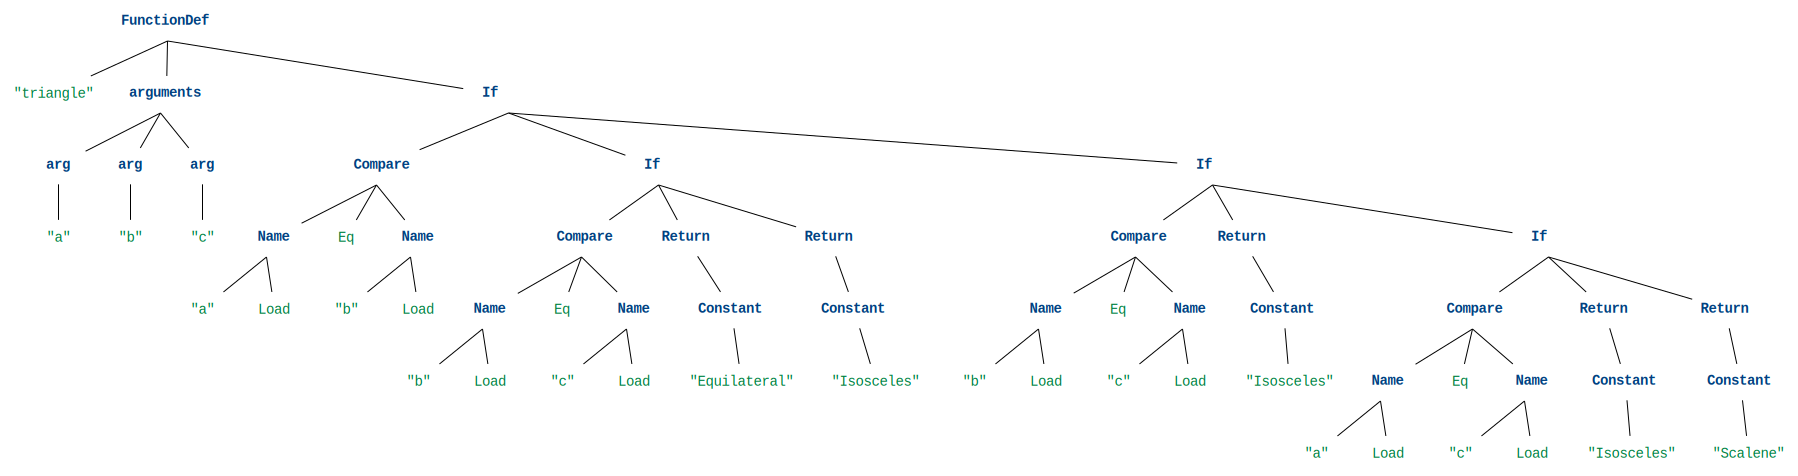

In [234]:
from fuzzingbook.bookutils import rich_output

if rich_output():
    import showast
    showast.show_ast(triangle_ast)

In [235]:
import astunparse

print_content(astunparse.unparse(triangle_ast), '.py')

def triangle(a, b, c):
    if (a == b):
        if (b == c):
            return 'Equilateral'
        else:
            return 'Isosceles'
    elif (b == c):
        return 'Isosceles'
    elif (a == c):
        return 'Isosceles'
    else:
        return 'Scalene'

#### 简单的变异例子

现在让我们去突变一下triangle()程序。产生这个程序的有效突变版本的一个简单的方法是用pass替换它的一些语句。

MuFunctionAnalyzer是负责测试套件突变分析的主类。它接受要测试的函数。它通过使用上面讨论的函数，对给出的源代码进行一次解析和解读，将其规范化。这是必要的，以确保以后原始和突变体之间的差异不会因为空白、注释等的不同而脱轨。

In [236]:


class MuFunctionAnalyzer:
    def __init__(self, fn, log = False) -> None:
        self.fn = fn
        self.name = fn.__name__
        src = inspect.getsource(fn)
        self.ast = ast.parse(src)
        self.src = astunparse.unparse(self.ast)
        self.mutator = self.mutator_object()
        self.nmutations = self.get_mutation_count()
        self.un_detected = set()
        self.mutants = []
        self.log = log

    def mutator_object(self, locations=None):
        return StmtDeletionMutator(locations)
    
    def register(self, m):
        self.mutants.append(m)

    def finish(self):
        pass
    # get_mutation_count()获取可用的可能突变的数量。我们将在后面看到如何实现这一点。
    def get_mutation_count(self):
        self.mutator.visit(self.ast)
        return self.mutator.count

class Mutator(ast.NodeTransformer):
    def __init__(self, mutate_location = -1):
        self.count = 0
        self.mutate_location = mutate_location

    def mutable_visit(self, node):
        self.count += 1
        if self.count == self.mutate_location:
            return self.mutation_visit(node)
        return self.generic_visit(node)

# 
# 简单地钩住了所有的语句处理访问者。它通过用pass替换给定的语句来执行突变。正如你所看到的，它访问所有种类的语句。
class StmtDeletionMutator(Mutator):
    def visit_Return(self, node): return self.mutable_visit(node)
    def visit_Delete(self, node): return self.mutable_visit(node)

    def visit_Assign(self, node): return self.mutable_visit(node)
    def visit_AnnAssign(self, node): return self.mutable_visit(node)
    def visit_AugAssign(self, node): return self.mutable_visit(node)

    def visit_Raise(self, node): return self.mutable_visit(node)
    def visit_Assert(self, node): return self.mutable_visit(node)

    def visit_Global(self, node): return self.mutable_visit(node)
    def visit_Nonlocal(self, node): return self.mutable_visit(node)

    def visit_Expr(self, node): return self.mutable_visit(node)

    def visit_Pass(self, node): return self.mutable_visit(node)
    def visit_Break(self, node): return self.mutable_visit(node)
    def visit_Continue(self, node): return self.mutable_visit(node)

class StmtDeletionMutator(StmtDeletionMutator):
   
    def mutation_visit(self, node): return ast.Pass()

MuFunctionAnalyzer(triangle).nmutations

# 我们需要一种方法来获得各个突变体。为此，我们将MuFunctionAnalyzer转换为一个可迭代函数。
class MuFunctionAnalyzer(MuFunctionAnalyzer):
    def __iter__(self):
        return PMIterator(self)
# PMIterator，也就是MuFunctionAnalyzer的迭代器类，定义如下。
class PMIterator:
    def __init__(self,pm) -> None:
        self.pm = pm
        self.idx = 0

    # next()方法返回相应的突变体。
    def __next__(self):
        i = self.idx
        if i >= self.pm.nmutations:
            self.pm.finish()
            raise StopIteration()
        self.idx += 1
        mutant = Mutant(self.pm, self.idx, log=self.pm.log)
        self.pm.register(mutant)
        return mutant
    
class Mutant:
    def __init__(self, pm, location, log=False) -> None:
        self.pm = pm
        self.i = location
        self.name = "%s_%s" % (self.pm.name, self.i)
        self._src = None
        self.tests = []
        self.detected = False
        self.log = log

for m in MuFunctionAnalyzer(triangle):
    print(m.name)


triangle_1
triangle_2
triangle_3
triangle_4
triangle_5


In [237]:
# 这些名字还有点笼统。让我们看看我们是否能对产生的突变有更多的了解。
# generate_mutant()简单地调用mutator()方法，并向mutator传递AST的副本。

class Mutant(Mutant):
    def generate_mutant(self, location):
        mutant_ast = self.pm.mutator_object(
            location
        ).visit(ast.parse(self.pm.src)) # copy

        return astunparse.unparse(mutant_ast)

    def src(self):
        if self._src is None:
            self._src = self.generate_mutant(self.i)
        return self._src

import difflib
# from fuzzingbook.MutationAnalysis import MuFunctionAnalyzer
# 该函数可以显示出修改前与修改后的差异
for mutant in MuFunctionAnalyzer(triangle):
    
    shape_src = mutant.pm.src
    for line in difflib.unified_diff(
        mutant.pm.src.split('\n'),
        mutant.src().split('\n'),
        fromfile=mutant.pm.name,
        tofile=mutant.name, n=3
    ):
        print(line)   

# 下面的结果显示已经完成了抽象语法树的变异

--- triangle

+++ triangle_1

@@ -3,7 +3,7 @@

 def triangle(a, b, c):
     if (a == b):
         if (b == c):
-            return 'Equilateral'
+            pass
         else:
             return 'Isosceles'
     elif (b == c):
--- triangle

+++ triangle_2

@@ -5,7 +5,7 @@

         if (b == c):
             return 'Equilateral'
         else:
-            return 'Isosceles'
+            pass
     elif (b == c):
         return 'Isosceles'
     elif (a == c):
--- triangle

+++ triangle_3

@@ -7,7 +7,7 @@

         else:
             return 'Isosceles'
     elif (b == c):
-        return 'Isosceles'
+        pass
     elif (a == c):
         return 'Isosceles'
     else:
--- triangle

+++ triangle_4

@@ -9,7 +9,7 @@

     elif (b == c):
         return 'Isosceles'
     elif (a == c):
-        return 'Isosceles'
+        pass
     else:
         return 'Scalene'
 
--- triangle

+++ triangle_5

@@ -11,5 +11,5 @@

     elif (a == c):
         return 'Isosceles'
     else:
-        return

In [238]:
s1 = ['bacon\n', 'eggs\n', 'ham\n', 'guido\n']
s2 = ['python\n', 'eggs\n', 'hamster\n', 'guido\n']

for line in difflib.unified_diff(s1, s2, fromfile="te1", tofile="te2"):
    print(line)

--- te1

+++ te2

@@ -1,4 +1,4 @@

-bacon

+python

 eggs

-ham

+hamster

 guido



In [239]:
class Mutant(Mutant):
    def diff(self):
        return '\n'.join(difflib.unified_diff(self.pm.src.split('\n'),
                        self.src().split('\n'),
                        fromfile='original',
                        tofile='mutant',
                        n=3
        ))



### 评价变异符

我们现在准备实现实际的评估。我们把我们的突变体定义为一个上下文管理器，它验证所有给定的断言是否成功。我们的想法是，我们可以写一些代码，如：
```python
for mutant in MuFunctionAnalyzer(function):
    with mutant:
        assert function(x) == y
```
并在突变体处于活动状态时（即with:下的代码块），原始函数被突变后的函数所取代。

当进入with块时，__enter__()函数被调用。它将突变函数创建为一个 Python 函数，并将其放在全局命名空间中，这样断言语句就会执行突变函数而不是原始函数。


In [240]:
class Mutant(Mutant):
    def __enter__(self):
        if self.log:
            print('->t %s' % self.name)
        c = compile(self.src(), '<mutant>', 'exec')
        eval(c, globals())

__exit__() 函数检查是否发生了异常 (即断言失败了，或者引发了其他错误)；如果是，它将突变标记为已检测到。最后，它恢复了原始的函数定义。

In [241]:
class Mutant(Mutant):
    def __exit__(self, exec_type, exec_value, trace_back):
        if self.log:
            print('<-\t %s' % self.name)
        if exec_type is not None:
            self.detected = True
            if self.log:
                print("detected %s" % self.name, exec_type, exec_value)
        
        globals()[self.pm.name] = self.pm.fn

        if self.log:
            print()
        
        return True



from fuzzingbook.ExpectError import ExpectTimeout

class MuFunctionAnalyzer(MuFunctionAnalyzer):
    # finish()方法只是在突变体上调用方法，检查突变体是否被发现，并返回结果。
    def finish(self):
        self.un_detected = {
            mutant for mutant in self.mutants if not mutant.detected
        }
    # 突变得分--测试套件检测到的突变体的比率--由score()计算。1.0分意味着所有的突变体都被发现；0.1分意味着只有10%的突变体被发现。
    def score(self):
        return (self.nmutations - len(self.un_detected)) / self.nmutations
        

In [242]:
import sys

for mutant in MuFunctionAnalyzer(triangle, log=True):
    with mutant:
        assert triangle(1, 1, 1) == 'Equilateral', "Equal Check1"
        assert triangle(1, 0, 1) != 'Equilateral', "Equal Check2"
        assert triangle(1, 0, 2) != 'Equilateral', "Equal Check3"
        
mutant.pm.score()
        

->t triangle_1
<-	 triangle_1
detected triangle_1 <class 'AssertionError'> Equal Check1

->t triangle_2
<-	 triangle_2

->t triangle_3
<-	 triangle_3

->t triangle_4
<-	 triangle_4

->t triangle_5
<-	 triangle_5



0.2

五个突变中只有一个导致了一个失败的断言。因此，weak_oracle()测试套件的突变得分是20%。

In [243]:
for mutant in MuFunctionAnalyzer(triangle):
    with mutant:
        weak_oracle(triangle)
    
mutant.pm.score()

0.2

In [244]:
def oracle():
    strong_oracle(triangle)

for mutant in MuFunctionAnalyzer(triangle, log=True):
    with mutant:
        oracle()

mutant.pm.score()

->t triangle_1
<-	 triangle_1
detected triangle_1 <class 'AssertionError'> 

->t triangle_2
<-	 triangle_2
detected triangle_2 <class 'AssertionError'> 

->t triangle_3
<-	 triangle_3
detected triangle_3 <class 'AssertionError'> 

->t triangle_4
<-	 triangle_4
detected triangle_4 <class 'AssertionError'> 

->t triangle_5
<-	 triangle_5
detected triangle_5 <class 'AssertionError'> 



1.0

也就是说，我们能够用strong_oracle()测试套件实现100%的突变得分。

下面是另一个例子。gcd()计算两个数字的最大公除数。

In [245]:
def gcd(a, b):
    if a < b:
        c = a
        a = b
        b = c

    while b != 0:
        c = a
        a = b
        b = c % b

    return a

# 开始测试，效率如何
for mutant in MuFunctionAnalyzer(gcd, log=True):
    with mutant:
        assert gcd(1, 0) == 1, "Minimal"
        assert gcd(0, 1) == 1, "Mirror"



->t gcd_1
<-	 gcd_1
detected gcd_1 <class 'UnboundLocalError'> local variable 'c' referenced before assignment

->t gcd_2
<-	 gcd_2
detected gcd_2 <class 'AssertionError'> Mirror

->t gcd_3
<-	 gcd_3

->t gcd_4
<-	 gcd_4

->t gcd_5
<-	 gcd_5

->t gcd_6
<-	 gcd_6

->t gcd_7
<-	 gcd_7
detected gcd_7 <class 'AssertionError'> Minimal



In [246]:
mutant.pm.score()

0.42857142857142855

### 模块和测试套件的突变器

考虑一下我们之前讨论的triangle()程序。正如我们所讨论的，产生这个程序的有效变异版本的一个简单方法是通过替换它的一些语句。

为了演示的目的，我们想把这个程序放在不同的文件中进行。我们可以通过在Python中产生一个模块对象，并将函数附加到它上面来实现。

In [247]:
import types

# types.module 创建动态模块
def import_code(code, name):
    module = types.ModuleType(name)
    exec(code, module.__dict__)
    return module

In [248]:
# shape_src = inspect.getsource(triangle)
shape = import_code(shape_src, 'shape')
shape.triangle(1,1,1)

'Equilateral'

In [249]:
import unittest

class StrongShapeTest(unittest.TestCase):

    def test_equilateral(self):
        assert shape.triangle(1, 1, 1) == 'Equilateral'

    def test_isosceles(self):
        assert shape.triangle(1, 2, 1) == 'Isosceles'
        assert shape.triangle(2, 2, 1) == 'Isosceles'
        assert shape.triangle(1, 2, 2) == 'Isosceles'

    def test_scalene(self):
        assert shape.triangle(1, 2, 3) == 'Scalene'

# 我们定义了一个辅助函数suit()，它可以查看一个给定的类并识别测试函数。
def suite(test_class):
    suite = unittest.TestSuite()
    for f in test_class.__dict__:
        if f.startswith('test_'):
            suite.addTest(test_class(f))
    return suite

# TestTriangle类中的测试可以用不同的测试运行器来调用。最简单的是直接调用TestCase的run()方法。
suite(StrongShapeTest).run(unittest.TestResult())

<unittest.result.TestResult run=3 errors=0 failures=0>

In [250]:
# TextTestRunner类提供了控制执行的粗鲁性的能力。它还允许人们在第一次失败时返回。
runner = unittest.TextTestRunner(verbosity=0, failfast=True)
runner.run(suite(StrongShapeTest))

----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [257]:
# Running the program under coverage is accomplished as follows:
from fuzzingbook.Coverage import Coverage
class VisuaCoverage(Coverage):
    def show_coverage(self, fn):
        src = inspect.getsource(fn)
        name = fn.__name__
        covered = set([lineno for method,
                       lineno in self._trace if method == name])
        for i, s in enumerate(src.split('\n')):
            print('%s %2d: %s' % ('#' if i + 1 in covered else ' ', i + 1, s))

with VisualCoverage() as cov:
    suite(StrongShapeTest).run(unittest.TestResult())

cov.show_coverage(triangle)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
class WeakShapeTest(unittest.TestCase):
    def test_equilateral(self):
        assert shape.triangle(1, 1, 1) == 'Equilateral'

    def test_isosceles(self):
        assert shape.triangle(1, 2, 1) != 'Equilateral'
        assert shape.triangle(2, 2, 1) != 'Equilateral'
        assert shape.triangle(1, 2, 2) != 'Equilateral'

    def test_scalene(self):
        assert shape.triangle(1, 2, 3) != 'Equilateral'

with VisualCoverage() as cov:
    suite(WeakShapeTest).run(unittest.TestResult())

cov.show_coverage(triangle)